In [ ]:
# exploratory notebook to work with ESM2, get embeddings, and get pairwise representation (attention)

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from Bio import SeqIO

In [75]:
# ec112 gp38
seq = 'MAVVGVPGWIGSSAANETGQRWMSQAAGQLRLGVPCWMSQFAGRSREIIHTLGADHNFNGQWFRDRCFEAGSAPIVFNITGDLVSYSKDVPLFFMYGDTPNEYVQLNIHGVTMYGRGGNGGSNSPGSAGGHCIQNDIGGRLRINNGGAIAGGGGGGGGGYYSPFSQMRLTFGGGGGRPFGAPGGSIDMQSGATAGTISAPGSGSVNGIYNGGNGGEVGSAGGRCNIRGQGSEYNGGAAGYAVIGSAPTWQNVGAIYGPRV'

polyg_idx = seq.find('GGGGG')
n_masks = 30

masked_seq = seq[:polyg_idx] + ('<mask>'*n_masks) + seq[polyg_idx+n_masks:]

In [133]:
from transformers import AutoTokenizer, EsmForMaskedLM

model_name = "facebook/esm2_t33_650M_UR50D"  # esm2_t6_8M_UR50D, esm2_t12_35M_UR50D, esm2_t30_150M_UR50D, esm2_t33_650M_UR50D, esm2_t36_3B_UR50D
tokenizer = AutoTokenizer.from_pretrained(model_name)  
model = EsmForMaskedLM.from_pretrained(model_name)

assert '<mask>' in masked_seq, "sequence must contain <mask> token"

# For masked_seq
inputs_masked = tokenizer(masked_seq, return_tensors="pt")
with torch.no_grad():
    logits_masked = model(**inputs_masked).logits

# For seq
inputs_seq = tokenizer(seq, return_tensors="pt")
with torch.no_grad():
    logits_seq = model(**inputs_seq).logits

# retrieve index of <mask>
mask_token_index = (inputs_masked.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
print(mask_token_index)

predicted_token_ids = logits_masked[0, mask_token_index].argmax(axis=-1)
print(predicted_token_ids, tokenizer.decode(predicted_token_ids), seq[polyg_idx:polyg_idx+n_masks])

# compare to the actual sequence
labels = inputs_seq["input_ids"]
# mask labels of non-<mask> tokens
labels = torch.where(inputs_masked.input_ids == tokenizer.mask_token_id, labels, -100)

outputs = model(**inputs_masked, labels=labels, output_hidden_states=True, output_attentions=True)
print(outputs.loss)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

tensor([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6]) G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G GGGGGGGGGYYSPFSQMRLTFGGGGGRPFG
tensor(2.0794, grad_fn=<NllLossBackward0>)


In [134]:
tokenizer.decode(logits_masked[0].argmax(axis=-1))

'<cls> M A V V G V P G W I G S S A A N E T G Q R W M S Q A A G Q L R L G V P G W M S Q A A G R S R E I I H T L G A D H N F N G Q W F R D R G F E A G S A P I V F N I T G D L V S Y S K D V P L F F M Y G D T P N E Y V T L N I H G G T M Y G R G G N G G S N S P G S A G G H C I Q N D I G G R L R I N N G G A I A G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G A P G G S I D G Q S G A T A G T G S A P G S G S V N G I Y N G G N G G E V G S A G G R G N I R G Q G S G Y N G G A A G Y A V I G S A P T W Q N V G A I Y G P R V <eos>'

In [135]:
tokenizer.decode(logits_seq[0].argmax(axis=-1))

'<cls> M A V V G V P G W I G S S A A N E T G Q R W M S Q A A G Q L R L G V P G W M S Q F A G R S R E I I V T L G A D H N F N G Q W F R D R G G E A G S A P I V F N I T G D L V S Y S K D V P A F F M Y G L T P N E Y V Q L N I H G G T M Y G R G G N G G S N S P G S A G G H A I Q N D I G G R L R I N N G G A I A G G G G G G G G G Y Y S P F S Q M R L T G G G G G G G P F G A P G G S I D G Q S G A T A G T I S A P G S G S V N G I Y N G G N G G E V G S A G G R G N I R G Q G S E Y N G G A A G Y A V I G S A P T W Q N V G A I Y G P R V <eos>'

In [136]:
model

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, 

In [137]:
# 0th hidden_state entry is embedding layer, take mean to get sequence embedding
# hidden_state dim: (batch_size, seq_len, hidden_size)

mean_embedding = outputs.hidden_states[0].mean(dim=1)
mean_embedding.shape

torch.Size([1, 1280])

In [138]:
# get attention weights as pairwise representation, using the last n layers
# attentions dim: (batch_size, num_heads, seq_len, seq_len)

attentions = outputs.attentions[-1:]
pairwise_repr = torch.stack(attentions).mean(dim=0).mean(dim=1)
pairwise_repr.shape

torch.Size([1, 262, 262])

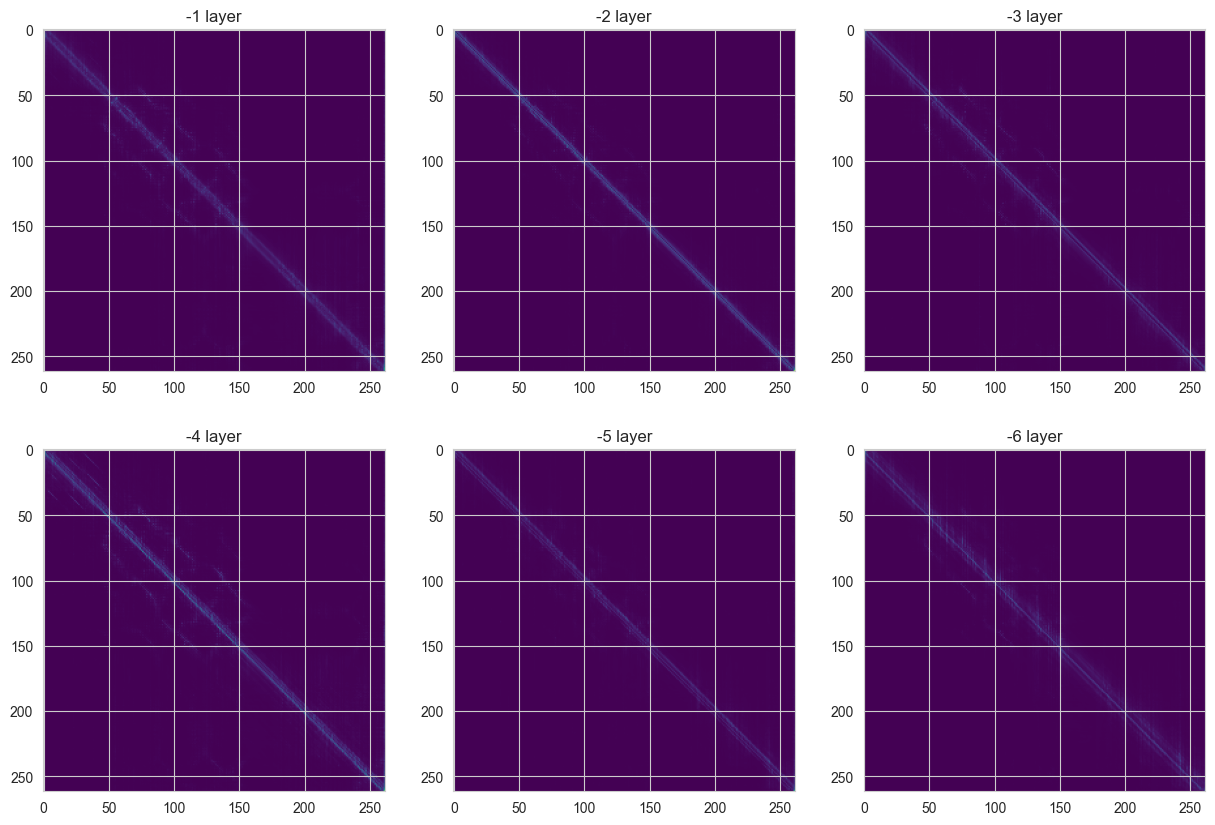

In [148]:
# plot attentions

n_layers = 6
n_cols = int(n_layers/2)

f, axes = plt.subplots(2, n_cols, figsize=(15, 10))
for i in range(0, n_layers):
    ax = axes[i//n_cols, i%n_cols]
    ax.imshow(outputs.attentions[-(i+1)].mean(dim=1).detach().numpy()[0], cmap='viridis')
    ax.set_title(f'-{i+1} layer')